# CA Traffic Collision Data Analysis
By: Mark Edward Nanquil
***
This analysis aims to do the following:
* perform exploratory data analysis (EDA) on the dataset by performing various visualization techniques
* extract insights and hypothesis based from the results of the EDA
* perform any statistical tests to verify if insights and hypothesis are statisically significant or not
* create a model that predicts number of injuries in a collision

Scope and limitations:
* Due to computational memory limitations, scope of the data is only between the years of 2019 and 2020.

## Import Libraries
***

Load libraries to be used in the analysis.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import warnings
warnings.filterwarnings("ignore") #remove warnings

import sqlite3 #reading the data
from datetime import datetime
import time

import numpy as np
import pingouin as pg # for t-test
from scipy import stats # for Levene's test and Shapiro's test
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation
***

Establish a connection with the *switrs* dataset 

In [3]:
con           = sqlite3.connect("/Users/markedwardnanquil/Downloads/switrs.sqlite")

Convert the *collisions*, *parties* and *victims* tables into a <code>pandas</code> dataframe. The output also includes the results of the <code>shape</code> command and <code>head</code> command.

In [4]:
df_collisions = pd.read_sql_query("SELECT * FROM collisions WHERE collision_date >= '2019-01-01'", con)
print(df_collisions.shape)
df_collisions.head()

(969539, 75)


,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,0081715,1941.0,11342,212,not chp,>250000,1941,los angeles,0,not chp,not chp,None,not chp,003,PATTERSON ST,ATLANTIC AV,0.0,None,1.0,cloudy,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,2.0,vehicle code violation,None,speeding,22350.0,None,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,0,0,1.0,NaN,None,None,0,0,0,0,0,0,0,0,0.0,None,None,NaN,NaN,2020-03-14,07:45:00,2020-06-22
1,0726202,3600.0,8945,064,not chp,50000 to 100000,3612,san bernardino,0,not chp,not chp,None,not chp,005,AMARGOSA,MARICOPA RD,0.0,None,NaN,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,1.0,vehicle code violation,None,speeding,22350.0,None,misdemeanor,hit object,fixed object,no pedestrian involved,dry,normal,None,dark with street lights,none,0,0,0,0,0,1.0,NaN,passenger car,"passenger car, station",0,0,0,0,0,0,0,0,0.0,None,None,NaN,NaN,2020-07-26,02:50:00,2020-09-30
2,77779235,1941.0,11233,None,not chp,>250000,1941,los angeles,0,not chp,not chp,None,not chp,None,GLADYS AV,ANAHEIM ST,371.0,south,0.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,4.0,vehicle code violation,None,dui,23152.0,None,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,None,dark with street lights,none,0,0,0,0,0,1.0,1.0,passenger car,None,0,0,0,0,0,0,0,0,0.0,None,None,NaN,NaN,2021-02-24,23:56:00,2021-03-26
3,8008483,5604.0,4868,None,not chp,100000 to 250000,5604,ventura,0,not chp,not chp,None,not chp,011,W KENTWOOD DR,H ST,100.0,east,0.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,3.0,vehicle code violation,None,dui,23152.0,A,not hit and run,rear end,parked motor vehicle,no pedestrian involved,wet,normal,None,dark with street lights,functioning,0,0,0,0,0,1.0,1.0,passenger car,"passenger car, station",0,0,0,0,0,0,0,0,0.0,None,None,34.2176,-119.1868,2020-10-05,22:36:00,2021-01-02
4,8008484,1942.0,18124,1494,not chp,>250000,1942,los angeles,0,not chp,not chp,N,not chp,3A101,IMPERIAL HWY,MAIN ST,33.0,east,0.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,pain,0,2,2.0,vehicle code violation,None,speeding,22350.0,None,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,dark with street lights,functioning,0,0,0,0,1,1.0,NaN,truck or truck tractor,two axle truck,0,0,2,0,0,0,0,0,0.0,None,None,NaN,NaN,2020-08-06,21:25:00,2020-11-20


In [5]:
df_parties = pd.read_sql_query("""SELECT * FROM parties 
                                    WHERE case_id IN (SELECT DISTINCT case_ID FROM collisions WHERE collision_date >= '2019-01-01')""", con)
print(df_parties.shape)
df_parties.head()

(1910665, 32)


,id,case_id,party_number,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,cellphone_in_use,cellphone_use_type,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,statewide_vehicle_type,chp_vehicle_type_towing,chp_vehicle_type_towed,party_race
0,1,0081715,1,driver,1,female,35.0,not applicable,not applicable,north,air bag deployed,lap/shoulder harness used,proof of insurance obtained,NaN,0.0,cellphone not in use,NaN,None,None,None,None,none apparent,None,0,0,proceeding straight,2007.0,ford,None,None,None,other
1,2,0081715,2,driver,0,female,43.0,not applicable,not applicable,north,air bag not deployed,lap/shoulder harness used,proof of insurance obtained,NaN,0.0,cellphone not in use,NaN,None,None,None,None,none apparent,None,0,0,proceeding straight,2019.0,None,None,None,None,hispanic
2,3,0726202,1,driver,1,None,NaN,impairment unknown,G,north,None,None,None,NaN,NaN,None,NaN,None,None,None,None,none apparent,None,0,0,proceeding straight,2005.0,None,passenger car,"passenger car, station",None,None
3,5560682,77779235,1,driver,1,male,53.0,"had been drinking, under influence",None,south,air bag deployed,None,None,NaN,NaN,no cellphone/unknown,NaN,None,None,None,None,none apparent,None,0,0,backing,1998.0,ford,passenger car,None,None,black
4,5560683,77779235,2,parked vehicle,0,None,NaN,not applicable,not applicable,None,None,None,not applicable,NaN,NaN,no cellphone/unknown,NaN,None,None,None,None,none apparent,None,0,0,parked,2008.0,None,passenger car,None,None,None


In [6]:
df_victims = pd.read_sql_query("""SELECT * FROM victims
                                  WHERE case_id IN (SELECT DISTINCT case_ID 
                                                    FROM collisions WHERE collision_date >= '2019-01-01')""", con)
print(df_victims.shape)
df_victims.head()

(694522, 11)


,id,case_id,party_number,victim_role,victim_sex,victim_age,victim_degree_of_injury,victim_seating_position,victim_safety_equipment_1,victim_safety_equipment_2,victim_ejected
0,3078083,8008484,2,driver,male,33.0,complaint of pain,driver,air bag not deployed,lap/shoulder harness used,None
1,3078084,8008484,2,passenger,male,NaN,complaint of pain,passenger seat 3,air bag not deployed,lap/shoulder harness used,None
2,3078087,8008488,2,driver,male,26.0,complaint of pain,driver,air bag not deployed,lap/shoulder harness used,not ejected
3,3078088,8008488,2,passenger,female,26.0,complaint of pain,passenger seat 3,air bag not deployed,lap/shoulder harness used,not ejected
4,3078090,8008491,1,driver,female,34.0,complaint of pain,driver,air bag deployed,lap/shoulder harness used,not ejected


Merge the the *collisions*, *parties* and *victims* tables into one <code>pandas</code> dataframe. The output also includes the results of the <code>shape</code> command and <code>head</code> command.

In [7]:
df0 = pd.merge(left    = df_collisions,
               right   = df_parties,
               left_on = 'case_id',
               right_on= 'case_id',
               how     = 'left')

In [8]:
df_switrs = pd.merge(left    = df0,
                    right    = df_victims,
                    left_on  = 'case_id',
                    right_on = 'case_id',
                    how      = 'left')

In [9]:
print(df_switrs.shape)
df_switrs.head()

(2522451, 116)


,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date,id_x,party_number_x,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,cellphone_in_use,cellphone_use_type,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,statewide_vehicle_type,chp_vehicle_type_towing,chp_vehicle_type_towed,party_race,id_y,party_number_y,victim_role,victim_sex,victim_age,victim_degree_of_injury,victim_seating_position,victim_safety_equipment_1,victim_safety_equipment_2,victim_ejected
0,0081715,1941.0,11342,212,not chp,>250000,1941,los angeles,0,not chp,not chp,None,not chp,003,PATTERSON ST,ATLANTIC AV,0.0,None,1.0,cloudy,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,2.0,vehicle code violation,None,speeding,22350.0,None,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,0,0,1.0,NaN,None,None,0,0,0,0,0,0,0,0,0.0,None,None,NaN,NaN,2020-03-14,07:45:00,2020-06-22,1,1,driver,1,female,35.0,not applicable,not applicable,north,air bag deployed,lap/shoulder harness used,proof of insurance obtained,NaN,0.0,cellphone not in use,NaN,None,None,None,None,none apparent,None,0,0,proceeding straight,2007.0,ford,None,None,None,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0081715,1941.0,11342,212,not chp,>250000,1941,los angeles,0,not chp,not chp,None,not chp,003,PATTERSON ST,ATLANTIC AV,0.0,None,1.0,cloudy,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,2.0,vehicle code violation,None,speeding,22350.0,None,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,0,0,1.0,NaN,None,None,0,0,0,0,0,0,0,0,0.0,None,None,NaN,NaN,2020-03-14,07:45:00,2020-06-22,2,2,driver,0,female,43.0,not applicable,not applicable,north,air bag not deployed,lap/shoulder harness used,proof of insurance obtained,NaN,0.0,cellphone not in use,NaN,None,None,None,None,none apparent,None,0,0,proceeding straight,2019.0,None,None,None,None,hispanic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0726202,3600.0,8945,064,not chp,50000 to 100000,3612,san bernardino,0,not chp,not chp,None,not chp,005,AMARGOSA,MARICOPA RD,0.0,None,NaN,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,property damage only,0,0,1.0,vehicle code violation,None,speeding,22350.0,None,misdemeanor,hit object,fixed object,no pedestrian involved,dry,normal,None,dark with street lights,none,0,0,0,0,0,1.0,NaN,passenger car,"passenger car, station",0,0,0,

Convert selected variables from *string* to *datetime* format.

In [10]:
df_switrs['collision_date']        = pd.to_datetime(df_switrs['collision_date'])
df_switrs['collision_date_month']  = df_switrs['collision_date'].dt.month
df_switrs['collision_date_year']   = df_switrs['collision_date'].dt.year

df_switrs['process_date']          = pd.to_datetime(df_switrs['process_date'])

df_switrs['collision_time_hour']   = pd.to_datetime(df_switrs['collision_time'], format="%H:%M:%S").dt.hour
df_switrs['collision_time_minute'] = pd.to_datetime(df_switrs['collision_time'], format="%H:%M:%S").dt.minute

## Exploratory Data Analysis
***
**Data Preparation**

For the data transformation, we perform the following steps:
* Filter for parties at fault from the parties table
* Merge the collisions table with filtered parties table

In [11]:
df_parties_at_fault = df_parties[df_parties['at_fault']==1]

In [12]:
df_collisions_with_parties = pd.merge( left     = df_collisions
                                     , right    = df_parties_at_fault
                                     , how      = 'inner'
                                     , left_on  = 'case_id'
                                     , right_on = 'case_id')

* <code>collision_date</code> was converted into date format
* Several variables were created: <code>collision_date</code>, <code>collision_date_month</code>, <code>collision_date_year</code>, <code>collision_time_hour</code>, <code>collision_time_minute</code>, <code>collision_date_day_of_week</code>

In [13]:
df_collisions_with_parties['collision_date']        = pd.to_datetime(df_collisions_with_parties['collision_date'])
df_collisions_with_parties['collision_date_month']  = df_collisions_with_parties['collision_date'].dt.month
df_collisions_with_parties['collision_date_year']   = df_collisions_with_parties['collision_date'].dt.year

df_collisions_with_parties['process_date']          = pd.to_datetime(df_collisions_with_parties['process_date'])

df_collisions_with_parties['collision_time_hour']   = pd.to_datetime(df_collisions_with_parties['collision_time'], format="%H:%M:%S").dt.hour
df_collisions_with_parties['collision_time_minute'] = pd.to_datetime(df_collisions_with_parties['collision_time'], format="%H:%M:%S").dt.minute

In [14]:
df_collisions_with_parties['collision_date_day_of_week']  = df_collisions_with_parties['collision_date'].dt.dayofweek

**Does the weather have an effect on the collisions? Are there seasons where collisions are more likely to occur?**

From the bar graph below, we can see that collisions are not significantly different from 2015 to 2019 for winter, spring, summer and fall.

In [15]:
df_weather = pd.read_sql_query("SELECT case_id, collision_date, collision_time, weather_1  FROM collisions WHERE collision_date >= '2015-01-01'", con)

In [16]:
df_weather['collision_date']        = pd.to_datetime(df_weather['collision_date'])
df_weather['collision_date_month']  = df_weather['collision_date'].dt.month
df_weather['collision_date_year']   = df_weather['collision_date'].dt.year
df_weather['collision_time_hour']   = pd.to_datetime(df_weather['collision_time'], format="%H:%M:%S").dt.hour
df_weather['collision_time_minute'] = pd.to_datetime(df_weather['collision_time'], format="%H:%M:%S").dt.minute

In [17]:
df_insight_weather     = pd.DataFrame(df_weather.groupby(['collision_date_year','collision_date_month','weather_1'])['case_id'].count())
df_insight_weather_idx = df_insight_weather.reset_index()

In [18]:
df_insight_weather_monthly = pd.DataFrame(df_weather.groupby(['collision_date_year','collision_date_month'])['case_id'].count())

In [19]:
df_insight_weather_monthly_idx = df_insight_weather_monthly.reset_index()

In [20]:
conditions = [
    (df_insight_weather_monthly_idx['collision_date_month']  <= 2),
    (df_insight_weather_monthly_idx['collision_date_month'] > 2) & (df_insight_weather_monthly_idx['collision_date_month'] <= 5),
    (df_insight_weather_monthly_idx['collision_date_month'] > 5) & (df_insight_weather_monthly_idx['collision_date_month'] <= 8),
    (df_insight_weather_monthly_idx['collision_date_month'] > 8) & (df_insight_weather_monthly_idx['collision_date_month'] <= 11),
    (df_insight_weather_monthly_idx['collision_date_month'] == 12)]

values = ['winter', 'spring', 'summer', 'fall', 'winter']

df_insight_weather_monthly_idx['season'] = np.select(conditions, values)

In [21]:
df_insight_weather_season  = pd.DataFrame(df_insight_weather_monthly_idx.groupby(['collision_date_year','season'])['case_id'].sum())
df_insight_weather_season1 = df_insight_weather_season.reset_index()
df_insight_weather_season2 = df_insight_weather_season1[df_insight_weather_season1['collision_date_year']<=2019]

Text(0.5, 0, 'Year')

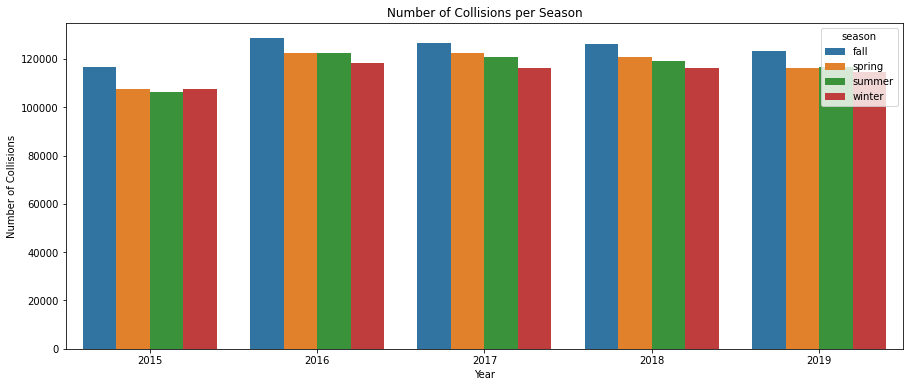

In [22]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x="collision_date_year", hue="season", y="case_id", data=df_insight_weather_season2)
ax.set_title('Number of Collisions per Season')
ax.set_ylabel('Number of Collisions')
ax.set_xlabel('Year')

**Who is usually at fault? Are the specific demographics(age/gender) that are more likely to be involved in accidents?**

Graphically we can see the following:
* Those belonging to the *less than 20, 21 - 25, 26 - 30* and *66 and above* age brackets have the highest number of collisions.
* Collisions where the gender at fault is male have higher number of collisions than female at fault gender. Unfortunately, we cannot verify this hypothesis using $t-$test to confirm if this is statistically significant or not.

**Data Preparation**

In [23]:
df_insight_gender     = pd.DataFrame(df_collisions_with_parties.groupby(['collision_date_year','collision_date_month','party_sex'])['case_id'].count())
df_insight_gender_idx = df_insight_gender.reset_index()
df_insight_gender_idx = df_insight_gender_idx[df_insight_gender_idx['party_sex'] != 'X']

In [24]:
df_insight_gender_M = df_insight_gender_idx[df_insight_gender_idx['party_sex']=='male']
df_insight_gender_F = df_insight_gender_idx[df_insight_gender_idx['party_sex']=='female']

In [25]:
df_insight_gender_M['collision_date'] = df_insight_gender_M['collision_date_month'].astype('str') + "-" + df_insight_gender_M['collision_date_year'].astype('str')
df_insight_gender_F['collision_date'] = df_insight_gender_F['collision_date_month'].astype('str') + "-" + df_insight_gender_F['collision_date_year'].astype('str')

In [26]:
conditions = [
    (df_collisions_with_parties['party_age'] <= 20),
    (df_collisions_with_parties['party_age'] > 20) & (df_collisions_with_parties['party_age'] <= 25),
    (df_collisions_with_parties['party_age'] > 25) & (df_collisions_with_parties['party_age'] <= 30),
    (df_collisions_with_parties['party_age'] > 30) & (df_collisions_with_parties['party_age'] <= 35),
    (df_collisions_with_parties['party_age'] > 35) & (df_collisions_with_parties['party_age'] <= 40),
    (df_collisions_with_parties['party_age'] > 40) & (df_collisions_with_parties['party_age'] <= 45),
    (df_collisions_with_parties['party_age'] > 45) & (df_collisions_with_parties['party_age'] <= 50),
    (df_collisions_with_parties['party_age'] > 50) & (df_collisions_with_parties['party_age'] <= 55),
    (df_collisions_with_parties['party_age'] > 55) & (df_collisions_with_parties['party_age'] <= 60),
    (df_collisions_with_parties['party_age'] > 60) & (df_collisions_with_parties['party_age'] <= 65),
    (df_collisions_with_parties['party_age'] > 65)]

values = ['20 and below', '21 - 25', '26 - 30', '31 - 35', '36 - 40', '41 - 45', '46 - 50', '51 - 55', '56 - 60', '61 - 65', '66 and above']

df_collisions_with_parties['age_bracket'] = np.select(conditions, values)

In [27]:
df_age_bracket     = pd.DataFrame(df_collisions_with_parties.groupby('age_bracket')['case_id'].count())
df_age_bracket_idx = df_age_bracket.reset_index()
df_age_bracket_2   = df_age_bracket_idx[df_age_bracket_idx['age_bracket']!='0']

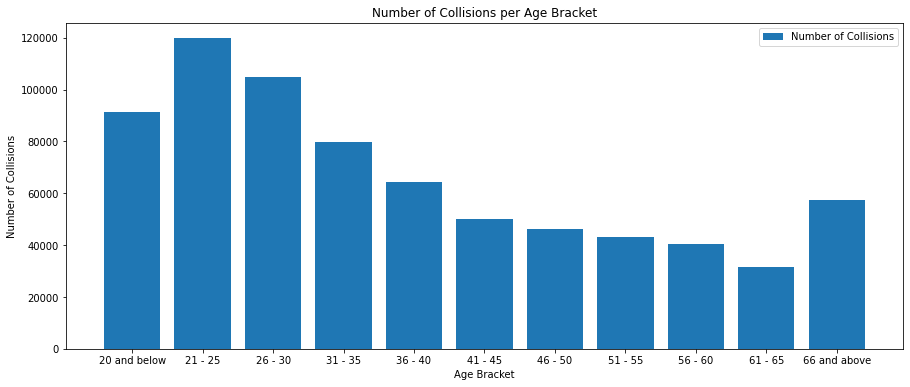

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
bar = ax.bar(df_age_bracket_2['age_bracket'], df_age_bracket_2['case_id'], label='Number of Collisions')

ax.set_title('Number of Collisions per Age Bracket')
ax.set_ylabel('Number of Collisions')
ax.set_xlabel('Age Bracket')
ax.legend()
plt.show()

**Visualization**

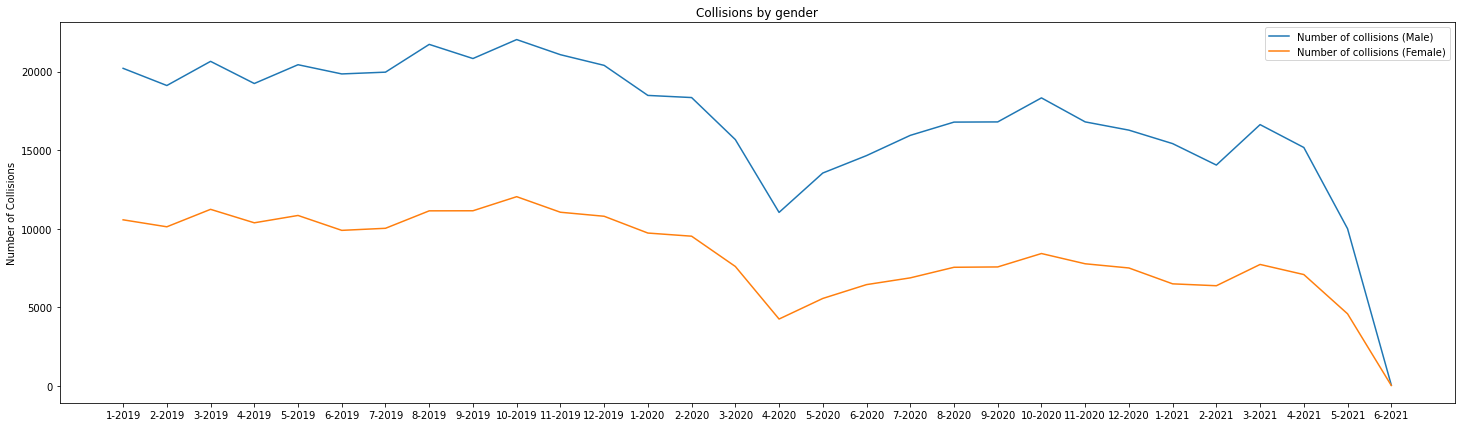

In [29]:
fig, ax = plt.subplots(figsize=(25,7))
line1 = ax.plot(df_insight_gender_M['collision_date'], df_insight_gender_M['case_id'], label='Number of collisions (Male)')
line2 = ax.plot(df_insight_gender_F['collision_date'], df_insight_gender_F['case_id'], label='Number of collisions (Female)')

ax.set_title('Collisions by gender')
ax.set_ylabel('Number of Collisions')
ax.legend()
plt.show()

**Hypothesis Testing:** We will use $t-$test to determine if the number of male drivers at fault is higher than female drivers at fault is statistically significant. To perform $t-$test, we have to check if our data satisfies the following assumptions of $t-$test:
* Number of male and female drivers at fault have equal variances (to be determined using Levene's Test)
* Number of male and female drivers at fault are normally distributed (to be determined using Shapiro's Test)

In [30]:
print(stats.levene(df_insight_gender_M['case_id'], df_insight_gender_F['case_id']))
print(stats.shapiro(df_insight_gender_M['case_id']))
print(stats.shapiro(df_insight_gender_F['case_id']))

LeveneResult(statistic=2.1280165696398075, pvalue=0.15002236046345724)
ShapiroResult(statistic=0.821190357208252, pvalue=0.00016359001165255904)
ShapiroResult(statistic=0.9116143584251404, pvalue=0.016346445307135582)


At $\alpha = 0.05$ using the $p-$values from Levene's Test and Shapiro's Test we can conclude the following:
* **Levene's Test:** Accept the null hypothesis. Assumption of equal variances for number of male and female drivers at fault is satisfied.
* **Shapiro's Test:** Assumption of normality for number of male and female drivers at fault is not satisfied.

Since the assumption of normality is not satisfied, we cannot proceed with $t-$test to confirm if the higher number of male drivers at fault is statistically significant than female drivers at fault.

## Insights
***

On March 11, 2020, the WHO has declared COVID-19 as a pandemic. In the US, President Donald Trump declared COVID-19 as a national emergency two days after. Considering the timeline of events, we will consider datapoints after March 11, 2020 as post COVID-19 data points. We will use 2019 as reference for pre-pandemic datapoints. 

### What is the effect of COVID-19 on the collisions? Are roads safer due to COVID?
Roads are safer during the COVID pandemic. Hypothesis testing shows that there is strong evidence that the number of collisions during COVID has significantly decreased on a $95\%$ confidence level. This result can also be verified as seen in the month-on-month line graph between pre-COVID and post-COVID and also in the descriptive statistics.

**Data Preparation:** Code below creates a table of number of collisions grouped per year and per month.

In [31]:
covid_df = df_switrs[['case_id','collision_date_month','collision_date_year']]

In [32]:
covid_df.sort_values('case_id', inplace=True)
covid_df.drop_duplicates('case_id', inplace=True)

covid_df0 = covid_df.reset_index()

covid_df1 = pd.DataFrame(covid_df.groupby(['collision_date_year','collision_date_month'])['case_id'].count())

covid_df2 = covid_df1.reset_index()
covid_df2.rename(columns={'case_id':'number_of_collisions'}, inplace=True)

In [33]:
pre_covid_df  = covid_df2[(covid_df2['collision_date_year'] == 2019)]
post_covid_df = covid_df2[(covid_df2['collision_date_year'] == 2020)]

In [34]:
pre_covid_collisions  = np.array(pre_covid_df['number_of_collisions'])
post_covid_collisions = np.array(post_covid_df['number_of_collisions'])

**Visualization:** It seems that number of collisions are much lower month-on-month during the COVID pandemic as seen in the line graph below.

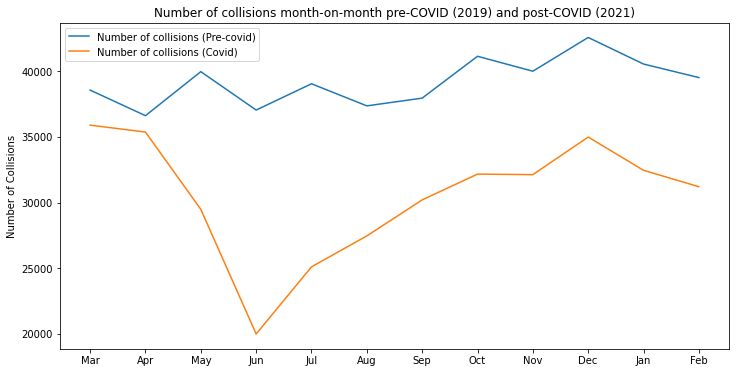

In [35]:
months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']

fig, ax = plt.subplots(figsize=(12,6))
line1 = ax.plot(months, pre_covid_collisions, label='Number of collisions (Pre-covid)')
line2 = ax.plot(months, post_covid_collisions, label='Number of collisions (Covid)')

ax.set_title('Number of collisions month-on-month pre-COVID (2019) and post-COVID (2021)')
ax.set_ylabel('Number of Collisions')
ax.legend()
plt.show()

**Hypothesis Testing:** We will use $t-$test to determine if the drop of average number of collisions in 2020 from 2019 is significant. To perform $t-$test, we have to check if our data satisfies the assumptions of $t-$test which are:
* pre-COVID and post-COVID datasets have equal variances (to be determined using Levene's Test)
* pre-COVID and post-COVID datasets are normally distributed (to be determined using Shapiro's Test)

In [36]:
print(stats.levene(pre_covid_collisions, post_covid_collisions))
print(stats.shapiro(pre_covid_collisions))
print(stats.shapiro(post_covid_collisions))

LeveneResult(statistic=3.5901612684604727, pvalue=0.0713412954565294)
ShapiroResult(statistic=0.9750810861587524, pvalue=0.9561166763305664)
ShapiroResult(statistic=0.9124079346656799, pvalue=0.22903797030448914)


**Descriptive statistics:** the average number of collisions have dropped from 39,196 in 2019 to 30,535 in 2020.

In [37]:
covid_df_desc   = pd.DataFrame(covid_df2.groupby('collision_date_year')['number_of_collisions'].describe())
covid_df_desc_T = covid_df_desc.transpose()
del covid_df_desc_T[2021]
covid_df_desc_T.style.format({2019:'{:.0f}',2020:'{:.0f}'})

collision_date_year,2019,2020
count,12,12
mean,39196,30535
std,1784,4601
min,36617,19985
25%,37806,28972
50%,39283,31664
75%,40140,33088
max,42575,35896


**Hypothesis Testing:** We will use $t-$test to determine if the drop of average number of collisions in 2020 from 2019 is significant. To perform $t-$test, we have to check if our data satisfies the assumptions of $t-$test which are:
* pre-COVID and post-COVID datasets have equal variances (to be determined using Levene's Test)
* pre-COVID and post-COVID datasets are normally distributed (to be determined using Shapiro's Test)

In [38]:
print(stats.levene(pre_covid_collisions, post_covid_collisions))
print(stats.shapiro(pre_covid_collisions))
print(stats.shapiro(post_covid_collisions))

LeveneResult(statistic=3.5901612684604727, pvalue=0.0713412954565294)
ShapiroResult(statistic=0.9750810861587524, pvalue=0.9561166763305664)
ShapiroResult(statistic=0.9124079346656799, pvalue=0.22903797030448914)


At $\alpha = 0.05$ using the $p-$values from Levene's Test and Shapiro's Test we can conclude the following:
* **Levene's Test:** Accept the null hypothesis. Assumption of equal variances for <code>pre_covid_collisions</code> and <code>post_covid_collisions</code> is satisfied.
* **Shapiro's Test:** Assumption of normality for <code>pre_covid_collisions</code> and <code>post_covid_collisions</code> datasets are satisfied.

We can now proceed with $t-$test.

In [39]:
res = pd.DataFrame(pg.ttest(pre_covid_collisions, post_covid_collisions, correction=False, alternative='greater'))
display(res[['T','dof','alternative','p-val']])

,T,dof,alternative,p-val
T-test,6.08071,22,greater,0.000002


**Null Hypothesis:** Mean of pre-COVID collisions is less than or equal to mean of post-COVID collisions.

**Alternative Hypothesis:** Mean of pre-COVID collisions is greater than the mean of post-COVID collisions.

At $\alpha = 0.05$ using the $p-$value from the $t-$test, we **reject** the null hypothesis. We **accept** the alternative hypothesis that is; the mean of pre-COVID collisions is greater than the mean of post-COVID collisions.

## Model Prediction
***

One of the objectives of this study is to create a model that predicts the number of injuries in a collision. The model that we will use to predict the number of injuries in a collision is called *Poisson Regression* which will be explained later in more detail. We will now explain the data preparation stage.

The following variables were pre-selected to be used as *predictors* for the *response* variable <code>injured_victimes</code>.

In [40]:
df_poisson_regression = df_collisions_with_parties[['injured_victims'
                                                    ,'party_count'
                                                    ,'party_age'
                                                    ,'vehicle_year'
                                                    ,'collision_date_month'
                                                    ,'collision_time_hour'
                                                    ,'collision_date_day_of_week'
                                                    ,'collision_date_year'
                                                    ,'collision_date']]
df_poisson_regression['vehicle_age'] = 2021 - df_poisson_regression['vehicle_year']
df_poisson_regression = df_poisson_regression[df_poisson_regression['injured_victims']>0]

In [41]:
df_poisson_regression_idx = df_poisson_regression.set_index('collision_date')

Imputation was also performed. Imputation is the process of artificially assigning values to missing data. Common practice is to use the mean as for continuous variables and the mode for discrete variables.

In [42]:
df_poisson_regression_idx['party_age']           = df_poisson_regression_idx['party_age'].fillna(np.mean(df_poisson_regression_idx['party_age']))
df_poisson_regression_idx['vehicle_age']         = df_poisson_regression_idx['vehicle_age'].fillna(np.mean(df_poisson_regression_idx['vehicle_age']))
df_poisson_regression_idx['party_count']         = df_poisson_regression_idx['party_count'].fillna(df_poisson_regression_idx['injured_victims'])
df_poisson_regression_idx['collision_time_hour'] = df_poisson_regression_idx['collision_time_hour'].fillna(stats.mode(df_poisson_regression_idx['collision_time_hour'])[0][0])

**Modelling**

As discussed earlier, Poisson Regression will be the model used to predict the number of <code>injured victims</code>. Poisson Regression is used to model count variables. Since a Poisson random variable is a count, its minimum value is zero and, in theory, the maximum is unbounded. Poisson Regression comes in the form:

<h3 align="center">$\log(\lambda) = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{n}x_{n}$</h3>

Examples of Poisson regression:

*Example 1*. The number of persons killed by mule or horse kicks in the Prussian army per year. Ladislaus Bortkiewicz collected data from 20 volumes of Preussischen Statistik. These data were collected on 10 corps of the Prussian army in the late 1800s over the course of 20 years.

*Example 2*. The number of people in line in front of you at the grocery store. Predictors may include the number of items currently offered at a special discounted price and whether a special event (e.g., a holiday, a big sporting event) is three or fewer days away.

*Example 3*. The number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math.

Sources:<br>
https://stats.idre.ucla.edu/r/dae/poisson-regression/<br>
https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html<br>
https://bookdown.org/roback/bookdown-BeyondMLR/ch-glms.html

In [43]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [44]:
df_y = df_poisson_regression_idx[['injured_victims']]
df_x = df_poisson_regression_idx[['party_count'
                             , 'party_age'
                             , 'vehicle_age'
                             , 'collision_date_month'
                             , 'collision_time_hour'
                             , 'collision_date_day_of_week']]

In [45]:
random_seed = 3141593
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.30, random_state=random_seed)

In [46]:
model   = sm.GLM(y_train, x_train, family=sm.families.Poisson())
results = model.fit()

At $\alpha = 0.05$ using the $p-$value from the results below, we can conclude that the variable <code>collision_date_month</code> is not significant.

Model interpretations per variable:
* The coefficient of the <code>party_count</code> variable is positive. The higher the party count, the higher the number of <code>injured_victims</code>.
* The coefficient of the <code>party_age</code> variable is negative. The higher the age of the party responsible, the lesser the number of <code>injured_victims</code>.
* The coefficient of the <code>vehicle_age</code> variable is negative. The higher the age of the vehicle, the lesser the number of <code>injured_victims</code>.
* The coefficient of the <code>collision_time_hour</code> variable is positive. The later the time of day is, the higher the number of <code>injured_victims</code>.
* The coefficient of the <code>collision_date_day_of_week</code> variable is positive. As the day is closer to the weekend, the higher the number of <code>injured_victims</code>.

In [47]:
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        injured_victims   No. Observations:               253694
Model:                            GLM   Df Residuals:                   253688
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2347e+05
Date:                Wed, 22 Sep 2021   Deviance:                       83785.
Time:                        00:06:57   Pearson chi2:                 1.07e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
party_count         

Predicted values for the test set was calculated using the model. We also calculate the following measures: MAE, MSE, and RMSE.

In [48]:
y_test['y_hat'] = results.predict(x_test)

We want the *MAE*, *MSE* and *RMSE* as low as possible when calculated against the test set.

In [49]:
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test['injured_victims'],y_test['y_hat']))
print("MSE:",metrics.mean_squared_error(y_test['injured_victims'],y_test['y_hat']))
print("RMSE:",np.sqrt(metrics.mean_absolute_error(y_test['injured_victims'],y_test['y_hat'])))

MAE: 0.5703367122697185
MSE: 0.6404870870846828
RMSE: 0.7552064037531186


In [50]:
y_rounded = y_test.round(0)

In [51]:
y_rounded1 = y_rounded.reset_index()

In [52]:
y_sorted = y_rounded1.sort_values('collision_date')

In [53]:
y_summarized  = y_sorted.groupby('collision_date')['injured_victims','y_hat'].sum()
y_summarized2 = y_summarized.reset_index()

The graph below shows the performancce of the model against the actual results.

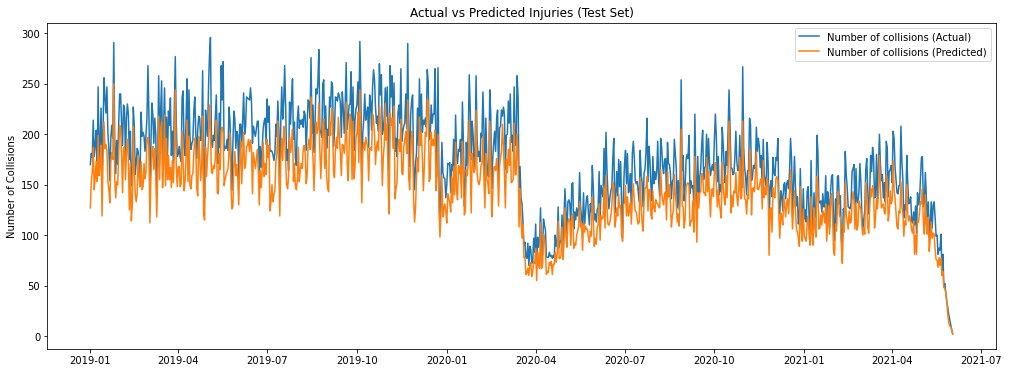

In [54]:
from matplotlib.pyplot import figure


fig, ax = plt.subplots(figsize=(17,6))
line1 = ax.plot(y_summarized2['collision_date'], y_summarized2['injured_victims'], label='Number of collisions (Actual)')
line2 = ax.plot(y_summarized2['collision_date'], y_summarized2['y_hat'], label='Number of collisions (Predicted)')

ax.set_title('Actual vs Predicted Injuries (Test Set)')
ax.set_ylabel('Number of Collisions')
ax.legend()
plt.show()

## Summary and Recommendations
***

To lessen traffic coalitions we recommend the following:
* Histogram of the number of collisions per age bracket is skewed to the right. That is, those in the younger age bracket have higher number of number of collisions. Stricter application process and guidelines is recommended for driver's license approval for applicants less than 31 years old.
* There is more more number collisions where the gender at fault is male. In lieu with the first recommendation, stricter application process and guidelines is recommended for driver's license approval for applicants who are male.
* While not significant (compared to other seasons), the highest number of collisions occur during the fall. More police officers on the road are recommended during the fall to improve safety on the road.
* Poisson Regression result shows that the later both the time of the day and day of the week is, the number of injured victims increase. This can be inferred due to alcohol consumption. It is highly recommended that people who recently consumed alcohol should not be allowed to drive and are suggested to take a taxi or ride-sharing platform (i.e. Uber) instead. 